In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data loading and preparation

print("Loading Bank Marketing Dataset...\n")

from ucimlrepo import fetch_ucirepo

# Fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# Get features and target
X = bank_marketing.data.features
y = bank_marketing.data.targets

# Combine for easier preprocessing
df = pd.concat([X, y], axis=1)

print(f"Dataset shape: {df.shape}")
print(f"Target distribution: {df['y'].value_counts().to_dict()}\n")


Loading Bank Marketing Dataset...

Dataset shape: (45211, 17)
Target distribution: {'no': 39922, 'yes': 5289}



In [3]:
# Encode categorical variables
for col in df.select_dtypes(include=['object']).columns:
    if col != 'y':
        df[col] = LabelEncoder().fit_transform(df[col])

# Encode target
df['y'] = df['y'].map({'no': 0, 'yes': 1})

# Split data
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training size: {len(X_train)} | Test size: {len(X_test)}\n")

Training size: 36168 | Test size: 9043



In [4]:
# testing functions
def run_experiment(model, name, description):
    """Run experiment and return results"""
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    auc = roc_auc_score(y_test, y_proba)
    cv_acc = cross_val_score(model, X_train, y_train, cv=5).mean()
    
    print(f"EXPERIMENT: {name}")
    print(f"Description: {description}")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy:  {test_acc:.4f}")
    print(f"  CV Accuracy:    {cv_acc:.4f}")
    print(f"  F1-Score:       {f1:.4f}")
    print(f"  ROC-AUC:        {auc:.4f}")
    print(f"  Overfitting:    {train_acc - test_acc:.4f}\n")
    
    return {
        'Name': name,
        'Train_Acc': train_acc,
        'Test_Acc': test_acc,
        'CV_Acc': cv_acc,
        'F1': f1,
        'AUC': auc,
        'Overfit': train_acc - test_acc
    }


In [5]:
# Experimenting 
results = []

exp1 = run_experiment(
    DecisionTreeClassifier(random_state=42),
    "DT-Baseline",
    "Default parameters"
)
results.append(exp1)

exp2 = run_experiment(
    DecisionTreeClassifier(max_depth=10, random_state=42),
    "DT-Depth10",
    "Max depth = 10"
)
results.append(exp2)

exp3 = run_experiment(
    RandomForestClassifier(n_estimators=100, random_state=42),
    "RF-100Trees",
    "100 estimators"
)
results.append(exp3)

exp4 = run_experiment(
    RandomForestClassifier(n_estimators=300, random_state=42),
    "RF-300Trees",
    "300 estimators"
)
results.append(exp4)

exp5 = run_experiment(
    AdaBoostClassifier(n_estimators=50, learning_rate=1.0, random_state=42),
    "Ada-Baseline",
    "50 estimators, LR=1.0"
)
results.append(exp5)

exp6 = run_experiment(
    AdaBoostClassifier(n_estimators=100, learning_rate=0.5, random_state=42),
    "Ada-Tuned",
    "100 estimators, LR=0.5"
)
results.append(exp6)


EXPERIMENT: DT-Baseline
Description: Default parameters
  Train Accuracy: 1.0000
  Test Accuracy:  0.8740
  CV Accuracy:    0.8745
  F1-Score:       0.4801
  ROC-AUC:        0.7050
  Overfitting:    0.1260

EXPERIMENT: DT-Depth10
Description: Max depth = 10
  Train Accuracy: 0.9281
  Test Accuracy:  0.8917
  CV Accuracy:    0.8984
  F1-Score:       0.4751
  ROC-AUC:        0.8328
  Overfitting:    0.0363

EXPERIMENT: RF-100Trees
Description: 100 estimators
  Train Accuracy: 1.0000
  Test Accuracy:  0.9005
  CV Accuracy:    0.9054
  F1-Score:       0.4994
  ROC-AUC:        0.9245
  Overfitting:    0.0995

EXPERIMENT: RF-300Trees
Description: 300 estimators
  Train Accuracy: 1.0000
  Test Accuracy:  0.9017
  CV Accuracy:    0.9054
  F1-Score:       0.5058
  ROC-AUC:        0.9267
  Overfitting:    0.0983

EXPERIMENT: Ada-Baseline
Description: 50 estimators, LR=1.0
  Train Accuracy: 0.8962
  Test Accuracy:  0.8912
  CV Accuracy:    0.8965
  F1-Score:       0.3827
  ROC-AUC:        0.8927


In [6]:
# summary
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

best = results_df.loc[results_df['Test_Acc'].idxmax()]
print(f"\n{'='*70}")
print(f"BEST MODEL: {best['Name']}")
print(f"  Test Accuracy: {best['Test_Acc']:.4f}")
print(f"  F1-Score: {best['F1']:.4f}")
print(f"  AUC: {best['AUC']:.4f}")
print("="*70)


        Name  Train_Acc  Test_Acc   CV_Acc       F1      AUC  Overfit
 DT-Baseline   1.000000  0.874046 0.874475 0.480146 0.704972 0.125954
  DT-Depth10   0.928058  0.891739 0.898391 0.475067 0.832826 0.036318
 RF-100Trees   1.000000  0.900476 0.905358 0.499444 0.924517 0.099524
 RF-300Trees   1.000000  0.901692 0.905358 0.505837 0.926656 0.098308
Ada-Baseline   0.896234  0.891187 0.896511 0.382685 0.892705 0.005048
   Ada-Tuned   0.894741  0.887427 0.893774 0.307483 0.890626 0.007314

BEST MODEL: RF-300Trees
  Test Accuracy: 0.9017
  F1-Score: 0.5058
  AUC: 0.9267



Visualization saved as 'results.png'


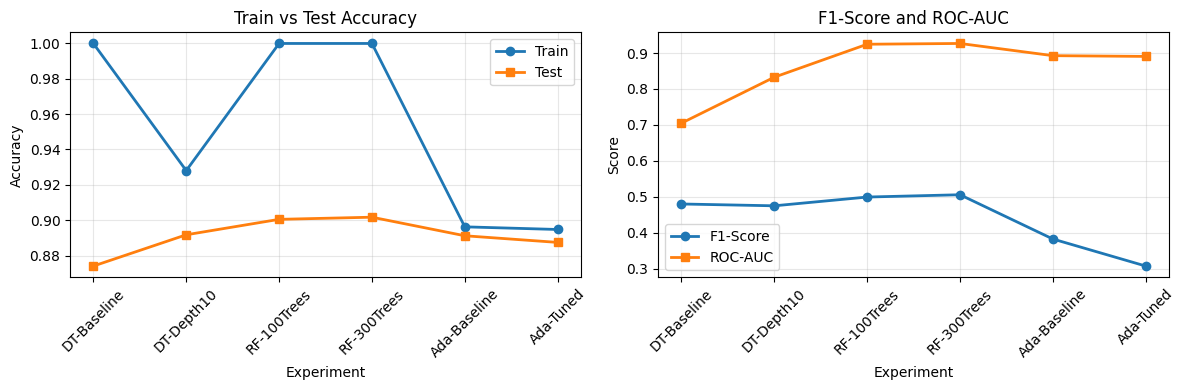

In [7]:

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax1 = axes[0]
x = range(len(results))
ax1.plot(x, [r['Train_Acc'] for r in results], 'o-', label='Train', linewidth=2)
ax1.plot(x, [r['Test_Acc'] for r in results], 's-', label='Test', linewidth=2)
ax1.set_xlabel('Experiment')
ax1.set_ylabel('Accuracy')
ax1.set_title('Train vs Test Accuracy')
ax1.set_xticks(x)
ax1.set_xticklabels([r['Name'] for r in results], rotation=45)
ax1.legend()
ax1.grid(alpha=0.3)

ax2 = axes[1]
ax2.plot(x, [r['F1'] for r in results], 'o-', label='F1-Score', linewidth=2)
ax2.plot(x, [r['AUC'] for r in results], 's-', label='ROC-AUC', linewidth=2)
ax2.set_xlabel('Experiment')
ax2.set_ylabel('Score')
ax2.set_title('F1-Score and ROC-AUC')
ax2.set_xticks(x)
ax2.set_xticklabels([r['Name'] for r in results], rotation=45)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results.png', dpi=150)
print("\nVisualization saved as 'results.png'")
